# A/B тест в интегрнет магазине

Совместно с отделом маркетинга был подготовлен список гипотез для увеличения выручи.  
В данной работе мы:  
- провеем приоритизацию гипотез, 
- запустим A/B-тест,  
- проанализируем результаты A/B-теста.

## Загрузка данных и подготовка к анализу

Импортируем необходимые для работы библиотеки.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import scipy.stats as stats
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta

Уберем ограничение по выводу строк, колонок и символов в записи

In [2]:
# Сброс ограничений на количество выводимых рядов
pd.set_option('display.max_rows', None)
 
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)
 
# Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)

### Загрузка данных

Запишем датасеты hypothesis.csv, orders.csv, visitors.csv в датафреймы hypothesis, orders и visitors соответственно, посмотрим на их первые 5 строк и посмотрим информацию.


In [3]:
try:
    hypothesis, orders, visitors = (
        pd.read_csv('/datasets/hypothesis.csv'),
        pd.read_csv('/datasets/orders.csv'),
        pd.read_csv('/datasets/visitors.csv')
    )


except:
    hypothesis, orders, visitors = (
        pd.read_csv('hypothesis.csv'),
        pd.read_csv('orders.csv'),
        pd.read_csv('visitors.csv')
    )

In [4]:
print(hypothesis.head())
print(hypothesis.info())

                                                                                                     Hypothesis  \
0            Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей   
1                                     Запустить собственную службу доставки, что сократит срок доставки заказов   
2  Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа   
3           Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар   
4                              Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей   

   Reach  Impact  Confidence  Efforts  
0      3      10           8        6  
1      2       5           4       10  
2      8       3           7        3  
3      8       3           3        8  
4      3       1           1        1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
D

Датафоейм **hypothesis**:  
  
`Hypothesis` — краткое описание гипотезы;  
`Reach` — охват пользователей по 10-балльной шкале;  
`Impact` — влияние на пользователей по 10-балльной шкале;  
`Confidence` — уверенность в гипотезе по 10-балльной шкале;  
`Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы. 
  
5 столбцов, 9 строк.

In [5]:
print(orders.head())
print(orders.info())

   transactionId   visitorId        date  revenue group
0     3667963787  3312258926  2019-08-15     1650     B
1     2804400009  3642806036  2019-08-15      730     B
2     2961555356  4069496402  2019-08-15      400     A
3     3797467345  1196621759  2019-08-15     9759     B
4     2282983706  2322279887  2019-08-15     2308     B
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
None


Датафоейм **orders**:  
  
`transactionId` — идентификатор заказа;  
`visitorId` — идентификатор пользователя, совершившего заказ;  
`date` — дата, когда был совершён заказ;  
`revenue` — выручка заказа;  
`group` — группа A/B-теста, в которую попал заказ.  
  
5 столбцов, 1197 строк.

In [6]:
print(visitors.head())
print(visitors.info())

         date group  visitors
0  2019-08-01     A       719
1  2019-08-02     A       619
2  2019-08-03     A       507
3  2019-08-04     A       717
4  2019-08-05     A       756
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None


Датафрейм **visitors**:  
  
`date` — дата;  
`group` — группа A/B-теста;  
`visitors` — количество пользователей в указанную дату в указанной группе A/B-теста.  
  
5 колонок, 62 строки.

### Переименование столбцов

Приведем название столбцов к нижнему и "змеиному" регистру.

In [7]:
hypothesis.columns = hypothesis.columns.str.lower()
orders.columns = ['transaction_id', 'visitor_id', 'date', 'revenue', 'group']

for i in (hypothesis, orders, visitors):
    print(i.columns)

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')
Index(['transaction_id', 'visitor_id', 'date', 'revenue', 'group'], dtype='object')
Index(['date', 'group', 'visitors'], dtype='object')


### Проверка на дубли

Проверим датафреймы на явные дубли.

In [8]:
for i in (hypothesis, orders, visitors):
    print(f'Явных дублей в датафреме {i.duplicated().sum()}')

Явных дублей в датафреме 0
Явных дублей в датафреме 0
Явных дублей в датафреме 0


Явных дублей нет.

### Преобразование данных

Преобразуем данные в столбцах с датой в формат дат.

In [9]:
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

print(visitors['date'].dtype)
print(orders['date'].dtype)


datetime64[ns]
datetime64[ns]


### Проверка на пропуски

Проверим датафреймы на пропуски.

In [10]:
for i in (hypothesis, orders, visitors):
    print(f'Пропусков в датафреме {i.isna().sum()}')

Пропусков в датафреме hypothesis    0
reach         0
impact        0
confidence    0
efforts       0
dtype: int64
Пропусков в датафреме transaction_id    0
visitor_id        0
date              0
revenue           0
group             0
dtype: int64
Пропусков в датафреме date        0
group       0
visitors    0
dtype: int64


Пропусков нет.

### Проверка групп A/B-тестирования

Проверим, сколько в действительности у нас групп тестирования и как на них делятся данные.

In [11]:
orders.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [12]:
print('Группы, представленные в датасетах')
for i in (orders, visitors):
    print(i['group'].unique())
    
print('Количество пользователей по группам в visitors')
print(visitors.groupby('group', as_index=False).agg({'visitors': 'sum'}))

print('Количество пользователей по группам в orders')
print(orders.groupby('group', as_index=False).agg({'visitor_id': 'nunique'}))

Группы, представленные в датасетах
['B' 'A']
['A' 'B']
Количество пользователей по группам в visitors
  group  visitors
0     A     18736
1     B     18916
Количество пользователей по группам в orders
  group  visitor_id
0     A         503
1     B         586


Как мы видим, в обоих датасетах только 2 группы.  
в датасете orders пользователи делятся не ровно пополам, но это и не обязательное условие, т.к. не каждый пользователь, из А/В группы обязательно должен совершить заказ.
В датасете visitors пользователи делятся не ровно пополам, но довольно близко. Посмотрим, в каком соотношении поделились.

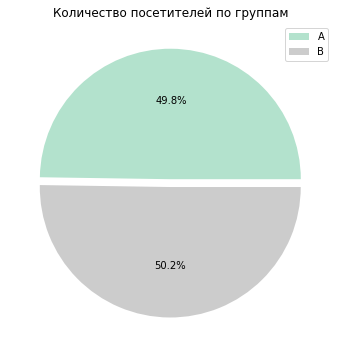

In [13]:

visitors_count = visitors.groupby('group').agg({'visitors': 'sum'})

visitors_count['visitors'].plot(kind="pie",
                                           autopct='%1.1f%%',
                                           explode=[0.05, 0.01],
                                           legend=True,
                                           title='Количество посетителей по группам',
                                           ylabel='',
                                           labeldistance=None,
                                           figsize=(6, 6),
                                           cmap='Pastel2');



Мы видим, что пользователей в группе B 50,2%, а в группе A - 49,8%.

Проверим, нет ли у нас пользователей, которые попали в группу A и B в заказах.

In [14]:
intersecting_id = (
    orders[orders['group']=='A'][['group','visitor_id']] \
    .merge(orders[orders['group']=='B'][['group','visitor_id']],
           left_on='visitor_id',
           right_on='visitor_id',
           how='inner',
          suffixes=['_a', '_b']) \
    .drop_duplicates(subset=['visitor_id']) \
    .reset_index())


print(intersecting_id.head())
print('Количество пересекающихся id',len(intersecting_id['visitor_id']))

   index group_a  visitor_id group_b
0      0       A  4069496402       B
1      1       A   199603092       B
2      5       A  3803269165       B
3      9       A  2378935119       B
4     29       A   237748145       B
Количество пересекающихся id 58


58 пользователей попали в группы A и B. Возможно, это id тестировщиков, а возможно была допущенка ошибка при делении трафика. Удалим их, чтобы они не повлияли на наш анализ.

In [15]:
intersecting_id_list = intersecting_id['visitor_id']

print('Строк в orders до фильтрации было', len(orders))
orders = orders.loc[~orders['visitor_id'].isin(intersecting_id_list)]
print('Строк в orders после фильтрации стало', len(orders))


Строк в orders до фильтрации было 1197
Строк в orders после фильтрации стало 1016


Мы очистили данные от пересекающихся пользователей из групп А и В.

**Вывод**  
Мы провели предобработку данных: переименовали столбцы, изменили тип данных в столбцах с датами, проверили на дубликаты и пропуски, очистили данные от пользователей, пересекающихся в группах А и В.  

## Приоритизация гипотез.

### Метод приоритизации гипотез ICE

Проведем приоритизацию гипотез методом ICE (от англ. impact, confidence, effort «влияние, уверенность, усилия»)

In [16]:
hypothesis['ice'] = (hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']).round(2)

print(hypothesis[['hypothesis', 'ice']].sort_values(by='ice', ascending=False));

                                                                                                     hypothesis  \
8                                                       Запустить акцию, дающую скидку на товар в день рождения   
0            Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей   
7              Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок   
6          Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию   
2  Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа   
1                                     Запустить собственную службу доставки, что сократит срок доставки заказов   
5                      Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов   
3           Изменить структура категорий, что увеличит конверсию, т.к. пользоват

Наиболее перспективные гипотезы по методу ICE 9, 1, 8:  
- Запустить акцию, дающую скидку на товар в день рождения  
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей  
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок

### Метод приоритизации гипотез RICE

Проведем приоритизацию гипотез методом RICE (от англ. reach, impact, confidence, effort «охва, влияние, уверенность, усилия»)

In [17]:
hypothesis['rice'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']

print(hypothesis[['hypothesis', 'rice']].sort_values(by='rice', ascending=False))

                                                                                                     hypothesis  \
7              Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок   
2  Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа   
0            Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей   
6          Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию   
8                                                       Запустить акцию, дающую скидку на товар в день рождения   
3           Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар   
1                                     Запустить собственную службу доставки, что сократит срок доставки заказов   
5                      Добавить страницу отзывов клиентов о магазине, что позвол

Наиболее перспективные гипотезы по методу RICE 8 (с большим отрывом), 3, 1:  
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок   
- Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа   
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей 

Разница в результатах в методах ICE и RICE заключается в том, что у гипотезы 8 максимальный охват (10 из 10), т.е. она затронет большее число пользователей, нежели гипотезы 3, 1 и 9.

**Вывод**  
По методу ICE лучше отдать приоритет гипотезам 9, 1, 8:  
- Запустить акцию, дающую скидку на товар в день рождения  
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей  
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок  
  
По методу RICE лучше отдать приоритет гипотезам 8 (с большим отрывом), 3, 1:  
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок   
- Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа   
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей 

## Анализ A/B-теста

Был проведен A/B-тест и получены результаты, которые описаны в датафреймах orders и visitors. Проведем их анализ.

### Кумулятивная выручка

Посчитаем и построим график кумулятивной выручки по группам.

Создадим вспомогательный датафрейм dates_groups с уникальными парами значений `date` и `group`, таблицы orders

In [18]:
dates_groups = orders[['date', 'group']].drop_duplicates()
dates_groups.head()

,date,group
0,2019-08-15,B
7,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A


Создадим вспомогательный датафрейм orders_aggregated содержащий:
- дату;
- группу A/B-теста;
- число уникальных заказов в группе теста по указанную дату включительно;
- число уникальных пользователей, совершивших хотя бы 1 заказ в группе теста по указанную дату включительно;
- суммарную выручку заказов в группе теста по указанную дату включительно.

In [19]:

orders_aggregated = (
    dates_groups.apply(
        lambda x: orders[np.logical_and(
            orders['date'] <= x['date'],
            orders['group'] == x['group'])] \
        .agg({'date':'max', 'group':'max', 'transaction_id':'nunique', 'visitor_id':'nunique', 'revenue':'sum'}),
        axis=1) \
    .sort_values(by=['date','group'])
)

orders_aggregated.head()

,date,group,transaction_id,visitor_id,revenue
55,2019-08-01,A,23,19,142779
66,2019-08-01,B,17,17,59758
175,2019-08-02,A,42,36,234381
173,2019-08-02,B,40,39,221801
291,2019-08-03,A,66,60,346854


Создадим вспомогательный датафрейм visitors_aggregated содержащий:  
- дату;  
- группу A/B-теста;  
- количество уникальных посетителей в группе теста по указанную дату включительно.

In [20]:
visitors_aggregated  = (
    dates_groups.apply(
        lambda x: visitors[np.logical_and(
            visitors['date'] <= x['date'], 
            visitors['group'] == x['group'])] \
        .agg({'date':'max', 'group':'max', 'visitors':'sum'}), 
        axis=1) \
    .sort_values(by=['date','group'])
)

visitors_aggregated.head()

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


Объединим датафреймы  orders_aggregated и visitors_aggregated по дате и группе.

In [21]:
cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])

cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulative_data.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


Разделим датафрейм cumulative_data по группам тестирования.

In [22]:
cumulative_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders', 'visitors']]

cumulative_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders', 'visitors']]

print(cumulative_revenue_a.head())
print()
print(cumulative_revenue_b.head())

        date  revenue  orders  visitors
0 2019-08-01   142779      23       719
2 2019-08-02   234381      42      1338
4 2019-08-03   346854      66      1845
6 2019-08-04   388030      77      2562
8 2019-08-05   474413      99      3318

        date  revenue  orders  visitors
1 2019-08-01    59758      17       713
3 2019-08-02   221801      40      1294
5 2019-08-03   288850      54      1803
7 2019-08-04   385740      68      2573
9 2019-08-05   475648      89      3280


Построим график кумулятивной выручки по группам.

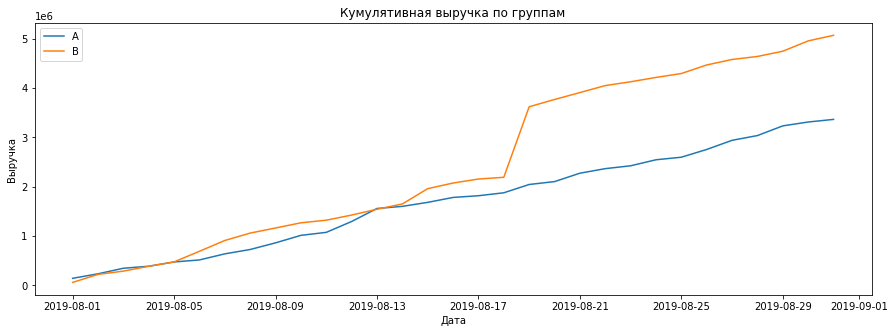

In [23]:
plt.figure(figsize=(15, 5))
plt.title('Кумулятивная выручка по группам')

plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')

plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.legend(loc='upper left')
plt.show();

У группы А кумулятивная выручка стабильно и равномерно растет. У группы B 19 августа 2019 есть резкий скачок, возможно, был сделан аномально большой заказ, который можно будет посчитать выбросом, или аномально большое количество заказов.  
По текущей картине группа B c 13 августа 2019 г. вырвалась вперед по выручке и продолжала лидировать  весь оставшийся период.

### Кумулятивный средний чек

Построим график кумулятивного среднего чека по группам тестирования.

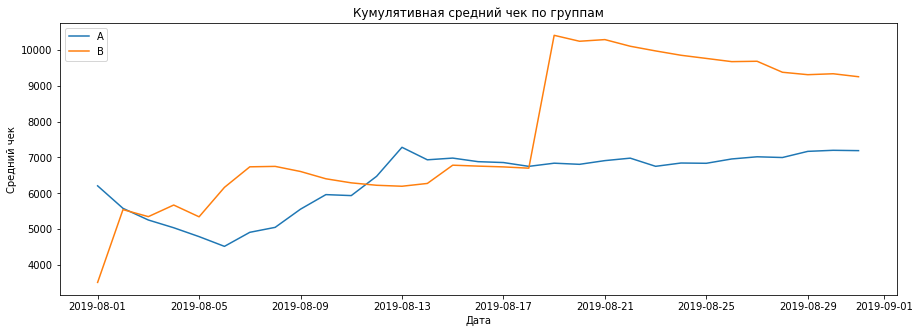

In [24]:
plt.figure(figsize=(15, 5))
plt.title('Кумулятивная средний чек по группам')
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'] / cumulative_revenue_a['orders'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'] / cumulative_revenue_b['orders'], label='B')
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.legend(loc='upper left')
plt.show();

В первые две недели теста не было определенного лидера по кумулятивному среднему чек, но у группы B 19 августа 2019 г. мы опять видим огромный скачок, значит, скорее всего, тогда был сделан все-таки аномально большой заказ, который может оказаться выбросом, а учитывая, что после него график группы B идет по низходящей сделать однозначный вывод, что группа B лидирует мы не можем.

### Относительное изменение кумулятивного среднего чека

Построим график относительного изменения кумулятивного среднего чека группы B к группе A.

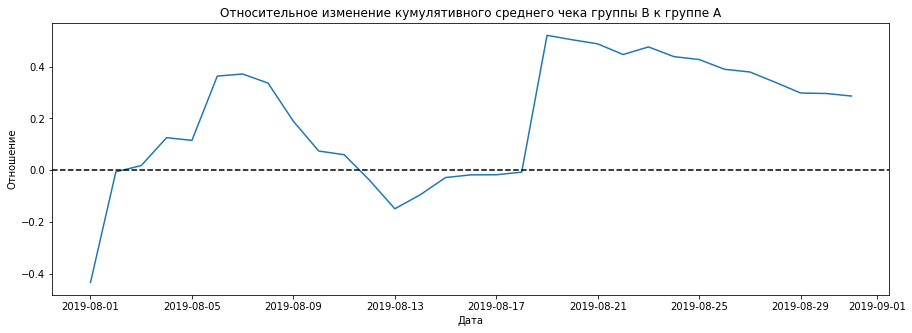

In [25]:
#объединим датафреймы по дате, добавив к столбцам выручки и 
#количества заказов в названии суффиксы соответствующей группы
merged_cumulative_revenue = cumulative_revenue_a.merge(cumulative_revenue_b, 
                                                       left_on='date', 
                                                       right_on='date', 
                                                       how='left', 
                                                       suffixes=['_a', '_b'])
#построим график
plt.figure(figsize=(15, 5))
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.plot(merged_cumulative_revenue['date'], 
         (merged_cumulative_revenue['revenue_b']/merged_cumulative_revenue['orders_b']) \
         /(merged_cumulative_revenue['revenue_a']/merged_cumulative_revenue['orders_a']) - 1)

plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Дата')
plt.ylabel('Отношение')
plt.show();

Мы видим, что результаты теста менялись несколько раз и довольно резко за наблюдаемый период, возможно, из-за аномальных заказов. Делать выводы по такому графику пока что рано.

### Кумулятивное среднее количество заказов на посетителя

Построим график кумулятивного среднего количества заказов на посетителя по группам.

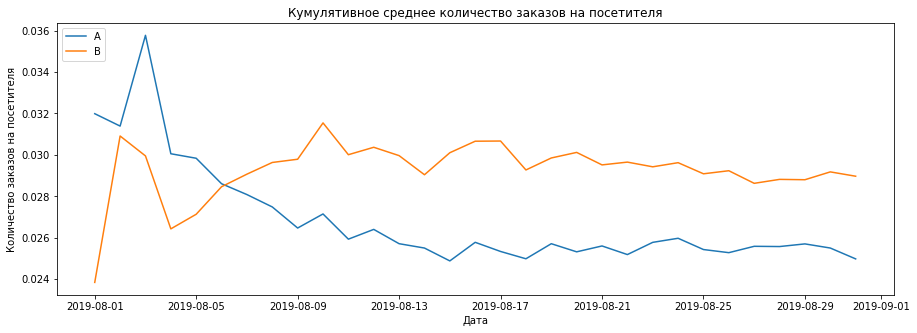

In [26]:
plt.figure(figsize=(15, 5))
plt.title('Кумулятивное среднее количество заказов на посетителя')

plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['orders'] / cumulative_revenue_a['visitors'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['orders'] / cumulative_revenue_b['visitors'], label='B')

plt.xlabel('Дата')
plt.ylabel('Количество заказов на посетителя')
plt.legend(loc='upper left')
plt.show();

Н аграфике мы видим, что срреднее кумулятивное количество заказов у группы B стабильно выше после 6 августа 2019, чем у группы A. Каких-либо радикальных скачков на графике мы не видим, возможно, наше предыдущее предположение, что на прошлых графиках скачки вызваны аномально большим заказом верны.

###  Относительное изменения кумулятивного среднего количества заказов на посетителя

Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. 

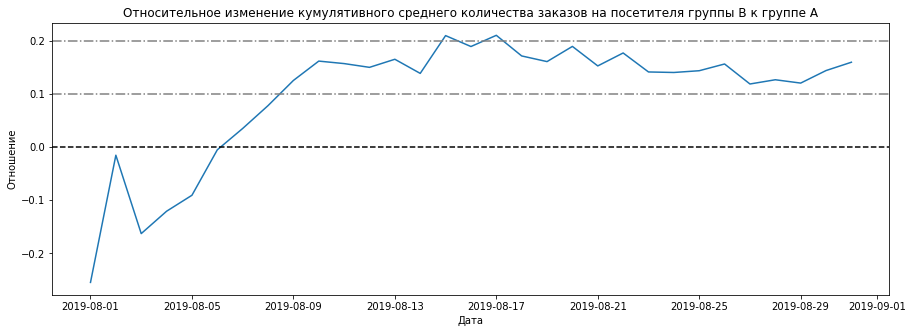

In [27]:
plt.figure(figsize=(15, 5))
plt.title('Относительное изменение кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.plot(merged_cumulative_revenue['date'], 
         ((merged_cumulative_revenue['orders_b']/merged_cumulative_revenue['visitors_b']) \
          /(merged_cumulative_revenue['orders_a']/merged_cumulative_revenue['visitors_a'])) - 1)

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='-.')
plt.axhline(y=0.2, color='grey', linestyle='-.')
plt.xlabel('Дата')
plt.ylabel('Отношение')
plt.show();

У группы B 6 августа 2019 стабильно большьше относительное кумулятивное среднее количество заказов на посетителя.

### Количество заказов по пользователям

Построим точечный график количества заказов по пользователям.

In [28]:
#создадим датафрейм, где сгруппируем количество заказов по пользователям.
orders_by_users= (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
orders_by_users.columns = ['visitor_id', 'orders']

print(orders_by_users.sort_values(by='orders', ascending=False).head(10))


     visitor_id  orders
908  3967698036       3
55    249864742       3
478  2108163459       3
687  2988190573       3
890  3908431265       3
138   611059232       3
632  2742574263       3
157   678354126       2
323  1404560065       2
452  1985475298       2


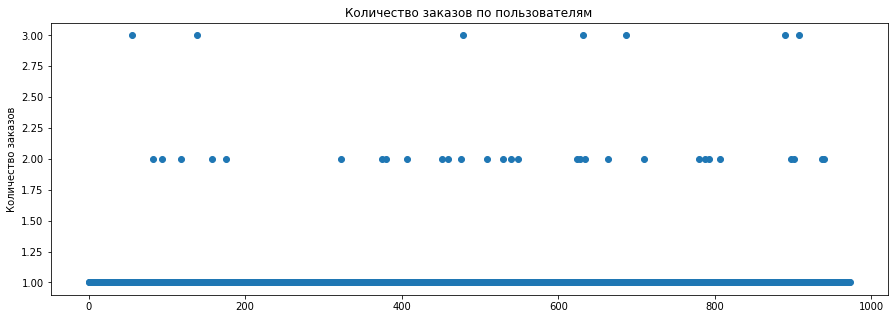

In [29]:
#построим график
plt.figure(figsize=(15, 5))
plt.title('Количество заказов по пользователям')
plt.scatter(orders_by_users.index, orders_by_users['orders'])
plt.ylabel('Количество заказов')
plt.show();

Мы видим, что осноаная масса пользователей совершает 1 заказ, пользователей, котррые заказали больше двух заказов немного, они могут оказаться аномальными.

### 95-й и 99-й перцентили количества заказов на пользователя

Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. 

In [30]:
print(np.percentile(orders_by_users['orders'], [95, 99]))

[1. 2.]


Не больше 5% пользователей сделали более 1 заказа, и не более 1% больше 2 заказов.  
Для дальнейшего анализа можно будет ограничить по 99 перценталю - 2 заказами на пользователя.

### Стоимость заказов

Построим точечный график стоимостей заказов.

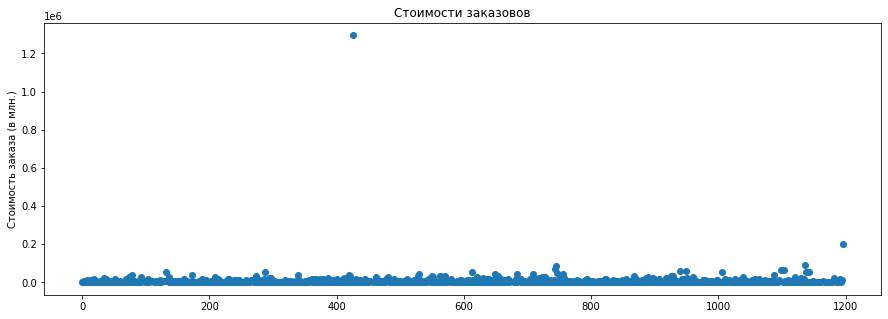

In [31]:
plt.figure(figsize=(15, 5))
plt.title('Стоимости заказовов')
plt.scatter(orders.index, orders['revenue'])
plt.ylabel('Стоимость заказа (в млн.)')
plt.show();

Стоимость заказов обычно не превышает 100 000, есть 2 явно аномально больших заказов, один на 200 000, в второй на целых 1 200 000.

### 95-й и 99-й перцентили стоимости заказов

Посчитаем 95-й и 99-й перцентили стоимости заказов.

In [32]:
print(np.percentile(orders['revenue'], [95, 99]))

[26785. 53904.]


Не больше 5% заказов стиоимостью выше 28 000, и не более 1% больше 58233,2.  
Для дальнейшего анализа можно будет ограничить стоимость заказа по 99 перцентялю -  53904.

### Статистическая значимость различий в среднем количестве заказов на посетителя

Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. 

Для начала посдготовим "сырые" данные

Посчитаем количество посетителей по в день, а также кумулятивноое по датам по группам.

In [33]:

visitors_a_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_a_daily.columns = ['date', 'visitors_per_date_a']

visitors_a_cummulative = visitors_a_daily.apply(
    lambda x: visitors_a_daily[visitors_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_a': 'sum'}
    ),
    axis=1,
)
visitors_a_cummulative.columns = ['date', 'visitors_cummulative_a']

visitors_b_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_b_daily.columns = ['date', 'visitors_per_date_b']

visitors_b_cummulative = visitors_b_daily.apply(
    lambda x: visitors_b_daily[visitors_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_b': 'sum'}
    ),
    axis=1,
)
visitors_b_cummulative.columns = ['date', 'visitors_cummulative_b']

print(visitors_a_cummulative.head())
print(visitors_b_cummulative.head())

        date  visitors_cummulative_a
0 2019-08-01                     719
1 2019-08-02                    1338
2 2019-08-03                    1845
3 2019-08-04                    2562
4 2019-08-05                    3318
         date  visitors_cummulative_b
31 2019-08-01                     713
32 2019-08-02                    1294
33 2019-08-03                    1803
34 2019-08-04                    2573
35 2019-08-05                    3280


Посчитаем количество заказов в день, а также кумулятивноое по датам по группам.

In [34]:
orders_a_daily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': 'nunique', 'revenue': 'sum'})
)
orders_a_daily.columns = ['date', 'orders_per_date_a', 'revenue_per_date_a']

orders_a_cummulative = orders_a_daily.apply(
    lambda x: orders_a_daily[orders_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_a': 'sum', 'revenue_per_date_a': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_a_cummulative.columns = [
    'date',
    'orders_cummulative_a',
    'revenue_cummulative_a',
]

orders_b_daily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': 'nunique', 'revenue': 'sum'})
)
orders_b_daily.columns = ['date', 'orders_per_date_b', 'revenue_per_date_b']

orders_b_cummulative = orders_b_daily.apply(
    lambda x: orders_b_daily[orders_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_b': 'sum', 'revenue_per_date_b': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_b_cummulative.columns = [
    'date',
    'orders_cummulative_b',
    'revenue_cummulative_b',
]

print(orders_a_cummulative.head())
print(orders_b_cummulative.head())

        date  orders_cummulative_a  revenue_cummulative_a
0 2019-08-01                    23                 142779
1 2019-08-02                    42                 234381
2 2019-08-03                    66                 346854
3 2019-08-04                    77                 388030
4 2019-08-05                    99                 474413
        date  orders_cummulative_b  revenue_cummulative_b
0 2019-08-01                    17                  59758
1 2019-08-02                    40                 221801
2 2019-08-03                    54                 288850
3 2019-08-04                    68                 385740
4 2019-08-05                    89                 475648


Сгруппируем "сырые" данные.

In [35]:

data = (
    orders_a_daily.merge(
        orders_b_daily, left_on='date', right_on='date', how='left'
    )
    .merge(orders_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(orders_b_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_a_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_b_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_b_cummulative, left_on='date', right_on='date', how='left')
)

print(data.head(5))

        date  orders_per_date_a  revenue_per_date_a  orders_per_date_b  \
0 2019-08-01                 23              142779                 17   
1 2019-08-02                 19               91602                 23   
2 2019-08-03                 24              112473                 14   
3 2019-08-04                 11               41176                 14   
4 2019-08-05                 22               86383                 21   

   revenue_per_date_b  orders_cummulative_a  revenue_cummulative_a  \
0               59758                    23                 142779   
1              162043                    42                 234381   
2               67049                    66                 346854   
3               96890                    77                 388030   
4               89908                    99                 474413   

   orders_cummulative_b  revenue_cummulative_b  visitors_per_date_a  \
0                    17                  59758                 

Значение столбцов:  
`date` — дата;  
`revenue_per_date_a` — количество заказов в выбранную дату в группе A;  
`revenue_per_date_a` — суммарная выручка в выбранную дату в группе A;  
`orders_per_date_b` — количество заказов в выбранную дату в группе B;  
`revenue_per_date_b` — суммарная выручка в выбранную дату в группе B;  
`orders_cummulative_a` — суммарное число заказов до выбранной даты включительно в группе A;  
`revenue_cummulative_a` — суммарная выручка до выбранной даты включительно в группе A;  
`orders_cummulative_b` — суммарное количество заказов до выбранной даты включительно в группе B;  
`revenue_cummulative_b` — суммарная выручка до выбранной даты включительно в группе B;  
`visitors_per_date_a` — количество пользователей в выбранную дату в группе A;  
`visitors_per_date_b` — количество пользователей в выбранную дату в группе B;  
`visitors_cummulative_a` — количество пользователей до выбранной даты включительно в группе A;  
`visitors_cummulative_b` — количество пользователей до выбранной даты включительно в группе B.  

Посчитаем количество заказов на каждого пользователя.

In [36]:
orders_by_users_a = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
orders_by_users_a.columns = ['user_id', 'orders']

orders_by_users_b = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
orders_by_users_b.columns = ['user_id', 'orders']

print(orders_by_users_a.head())
print(orders_by_users_b.head())

    user_id  orders
0  11685486       1
1  54447517       1
2  66685450       1
3  78758296       1
4  85103373       1
    user_id  orders
0   5114589       1
1   6958315       1
2  39475350       1
3  47206413       1
4  48147722       1


Добавим в таблицу всех посетителей, и среди тех, кто не делал заказ, в графе количество заказов укажим ноль.

In [37]:
sample_a = pd.concat(
    [
        orders_by_users_a['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b = pd.concat(
    [
        orders_by_users_b['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print(sample_a.head())
print(sample_b.head())

0    1
1    1
2    1
3    1
4    1
Name: orders, dtype: int64
0    1
1    1
2    1
3    1
4    1
Name: orders, dtype: int64


Выдвенем нулевую гипотезу, что статистически значимых различий в среднем числе заказов между группами нет. Альтернативная гипотеза - статистически значимые различия в среднем числе заказов между группами есть. Проверим ее методом U-теста Манна-Уитни. Задаем уровень значимости alpha=0.05

In [38]:
alpha=0.05
print('p-value равен', '{0:.5f}'.format(stats.mannwhitneyu(sample_a, sample_b)[1]))

if stats.mannwhitneyu(sample_a, sample_b)[1] > alpha:
    print('Не отвергаем нулевую гипотезу, нет оснований считать группы разными')
else:
        print('Отвергаем нулевую гипотезу, есть основания считать группы разными')
        
print('Отношение среднего числа заказов группы B к A равно ', 
      '{0:.3f}'.format(sample_b.mean() / sample_a.mean() - 1))


p-value равен 0.01102
Отвергаем нулевую гипотезу, есть основания считать группы разными
Отношение среднего числа заказов группы B к A равно  0.160


P-value меньше 0.05, потому нулевую гипотезу отвергаем. Анализ «сырых данных» сообщает, что в среднем количестве заказов между группами есть статистически значимые различия. Относительный прирост среднего группы B к конверсии группы A равен 16%.


### Cтатистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

Теперь проверим статистическую значимость различий в среднем чеке между сегментами. Нулевая гипотеза: различий в среднем чеке между группами нет. Альтернативная гипотеза: различия в среднем чеке между группами есть. 

In [39]:
alpha = 0.05
print('p-value равен', '{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], 
                                          orders[orders['group']=='B']['revenue'])[1]))

if stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], 
                                          orders[orders['group']=='B']['revenue'])[1] > alpha:
    print('Не отвергаем нулевую гипотезу, нет оснований считать группы разными')
else:
        print('Отвергаем нулевую гипотезу, есть основания считать группы разными')
        
print('Отношение среднего чека группы B к A равно', '{0:.3f}'.format(orders[orders['group']=='B']['revenue'] \
                       .mean()/orders[orders['group']=='A']['revenue'].mean()-1))


p-value равен 0.829
Не отвергаем нулевую гипотезу, нет оснований считать группы разными
Отношение среднего чека группы B к A равно 0.287


P-value значительно больше 0.05. Значит, нет причин отвергать нулевую гипотезу, нет оснований считать группы разными.  
Средний чек группы B больше среднего чека группы А.

### Cтатистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

Прежде чем считать статистическую значимость, посмотрим, сколько пользователей сделали более 2 заказов (99 перценталь), и сколько пользователей сделали заказ более чем на 53 904 (99 перценталь).

In [40]:
users_with_many_orders = pd.concat(
    [
        orders_by_users_a[orders_by_users_a['orders'] > np.percentile(orders_by_users['orders'], 
                                                                      [99])[0]]['user_id'],
        orders_by_users_b[orders_by_users_b['orders'] > np.percentile(orders_by_users['orders'], 
                                                                      [99])[0]]['user_id'],
    
    ],
    axis=0,
)
users_with_expensive_orders = orders[orders['revenue'] > np.percentile(orders['revenue'], [99])[0]]['visitor_id']
abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormal_users.head(5))
print(abnormal_users.shape[0])

1099    148427295
33      249864742
58      611059232
949     887908475
744     888512513
dtype: int64
16


16 аномальных пользователей.

Посмотрим, как они влияют на результаты теста. Посчитаем статистическую значимость различий в среднем количестве заказов между группами теста по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста

In [41]:
sample_a_filtered = pd.concat(
    [
        orders_by_users_a[
            np.logical_not(orders_by_users_a['user_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b_filtered = pd.concat(
    [
        orders_by_users_b[
            np.logical_not(orders_by_users_b['user_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print(sample_a_filtered.head())
print()
print(sample_b_filtered.head())

0    1
1    1
2    1
3    1
4    1
Name: orders, dtype: int64

0    1
1    1
2    1
3    1
4    1
Name: orders, dtype: int64


Применим статистический критерий Манна-Уитни к полученным выборкам. Выдвенем нулевую гипотезу, что статистически значимых различий в среднем числе заказов между группами нет. Альтернативная гипотеза - статистически значимые различия в среднем числе заказов между группами есть.

In [42]:

alpha = 0.05

print('p-value равен', '{0:.5f}'.format(stats.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1]))
if stats.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1] > alpha:
    print('Не отвергаем нулевую гипотезу, нет оснований считать группы разными')
else:
        print('Отвергаем нулевую гипотезу, есть основания считать группы разными')
print('Отношение среднего чека группы B к A равно', '{0:.3f}'.format(sample_b_filtered.mean()/sample_a_filtered.mean()-1))

p-value равен 0.00702
Отвергаем нулевую гипотезу, есть основания считать группы разными
Отношение среднего чека группы B к A равно 0.189


Результаты не изменились, P-value меньше 0.05, потому нулевую гипотезу отвергаем. Анализ «сырых данных» сообщает, что в среднем количестве заказов между группами есть статистически значимые различия. Относительный прирост среднего количества заказов группы B к среднему количеству заказов группы A равен 14.8%.

### Cтатистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

Теперь проверим статистическую значимость различий в среднем чеке между сегментами по "очищенным". Нулевая гипотеза: различий в среднем чеке между группами нет. Альтернативная гипотеза: различия в среднем чеке между группами есть. 

In [43]:

print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], 
                                          orders[orders['group']=='B']['revenue'])[1]))

print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'] \
                       .mean()/orders[orders['group']=='A']['revenue'].mean()-1))


alpha = 0.05
print('p-value равен', 
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
        )[1]
    )
)

if stats.mannwhitneyu(orders[
    np.logical_and(
        orders['group'] == 'A',
        np.logical_not(orders['visitor_id'].isin(abnormal_users)),
    )
    ]['revenue'],
                      orders[
                          np.logical_and(
                              orders['group'] == 'B',
                              np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                          )
                      ]['revenue'],
                     )[1] > alpha:
    print('Не отвергаем нулевую гипотезу, нет оснований считать группы разными')
else:
        print('Отвергаем нулевую гипотезу, есть основания считать группы разными')


print('Отношение среднего чека группы B к A равно', 
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        - 1
    )
)

0.829
0.287
p-value равен 0.788
Не отвергаем нулевую гипотезу, нет оснований считать группы разными
Отношение среднего чека группы B к A равно -0.032


P-value все еще значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет.
Но средний чек группы B теперь меньше среднего чека группы А.

## Вывод

Мы провели предобаботку данных:  

- Переименовали часть столбцов - привели к “змеиному” регистру.
- Проверили данные на явные дубли и пропуски.
- Изменили тип данных в столбцах с датами, сделали типом datetime64.
- Очистили данные от пользователей, пересекающихся в группах А и В

Провели приоритезацию гипотез.  

По методу ICE лучше отдать приоритет гипотезам 9, 1, 8:  

- Запустить акцию, дающую скидку на товар в день рождения
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок

По методу RICE (т.е. с учетом охвата пользователей) лучше отдать приоритет гипотезам 8 (с большим отрывом), 3, 1:  

- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
- Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей

Изучили результаты A/B теста.  

Результаты по “сырым” данным:  

- В среднем количестве заказов на пользователя между группами есть статистически значимые различия. Относительный прирост среднего группы B к конверсии группы A равен 13.8%.
- Статистически значимых различий в среднем чеке заказа между группами нет. Средний чек группы B больше среднего чека группы А на 26%.

Результаты по отфильтрованным данным:  

- В среднем количестве заказов на пользователя между группами есть статистически значимые различия. Относительный прирост среднего группы B к конверсии группы A равен 14.8%.
- Статистически значимых различий в среднем чеке заказа между группами нет. Средний чек группы B меньше среднего чека группы А на 2%.
  
  
**Рекомендации**  
Остановить A/B-тест. Мы увидели рост конверсии у группы B, что практически не повлияло на средний чек.  
проверить деление трафика на группы, т.к. есть 58 пользователей (их id в датафрейме intersecting_id_list), которые попали в обе группы тестирования, возможно это шибка деления, и, может быть, это id сотрудников компании, которые проводили тестирование.